# 1. Modeling preparation

In [37]:
# Import packages
import copy
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score, mean_squared_error
from sklearn.metrics import plot_confusion_matrix

# Traditional ML methods
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier



# Emsemble learning: Stacking

# NN

# LM


In [57]:
# Load Data
X = np.load('./Processed_data/X.npy')
Y = np.load('./Processed_data/Y.npy')

x_names = np.load('./Processed_data/x_names.npy')
y_names = np.load('./Processed_data/y_names.npy')

# X[~np.isnan(X).any(axis=1)].shape # drop 有nan的行
X = np.nan_to_num(X) # nan to 0

In [40]:
# train test split
def dataset_split(X,y,isVal=False):
    if isVal:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42)
        return X_train, y_train, X_test, y_test, X_val, y_val
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
        return X_train, y_train, X_test, y_test


# 可以用于train&test，以及grid search时的eval
def fit_eval_model(classifer,X_train, y_train,X_test, y_test,label_name = None):

    # Transform the test data using the vectorizer
    classifer.fit(X_train, y_train)

    # Predict the labels and probabilities for the test data
    y_pred_proba = classifer.predict_proba(X_test)[:, 1]
    y_pred = classifer.predict(X_test)
    
    
    # Calculate ROC and PRC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

    # Plot ROC and PRC
    plt.plot(fpr, tpr, label="ROC")
    plt.plot(recall, precision, label="PRC")
    plt.title(label_name+' :ROC VS PRC')
    plt.legend()
    plt.show()
    
    # Calculate F1-score, ac, recall, precision
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    mse = mean_squared_error(y_test, y_pred_proba)

    print(f"-----------------------{label_name}-----------------------")
    print(f"Accuracy: {accuracy}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")
    print(f"F1-score: {f1}")
    print(f"MSE: {mse}")


    return y_pred_proba, classifer,{'accuracy':accuracy,'recall':recall,'precision':precision,'f1':f1}


# 有空做一下交叉验证
def Kfold_cv(X,y,classifer,n_splits = 5,model_name = None):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    y_true = np.array([])
    y_proba = np.array([])

    for fold, (train_indices, test_indices) in enumerate(kf.split(X)):
        X_train, y_train = X[train_indices], y[train_indices]
        X_test, y_test = X[test_indices], y[test_indices]

        y_pred_proba, model, eval = fit_eval_model(X_train, y_train,X_test, y_test,classifer,label_name = f"Model {model_name}-Fold {fold}")

        # Concatenate the true labels and predicted probabilities for this fold
        y_true = np.concatenate([y_true, y_test])
        y_proba = np.concatenate([y_proba, y_pred_proba])


    # Compute and print the average F1-score across all folds
    eval = pd.DataFrame(eval).mean()
    print(eval)

    return model, eval

## 2.Training

In [58]:
# Initiate classifier (Binary)

binary_model_dict = {
    'LogisticRegression':LogisticRegression(penalty='l2',C=1.0,
    random_state=42,solver='saga', n_jobs=2),
    
    'KNeighborsClassifier':KNeighborsClassifier(n_neighbors=5, n_jobs=2),

    'DecisionTreeClassifier':DecisionTreeClassifier(max_depth=5, random_state=42),

    'RandomForestClassifier':RandomForestClassifier(n_estimators = 100,
    max_depth=5, random_state=42),

    'Xgboost':XGBClassifier(n_estimators = 100,max_depth=5, 
    random_state=42,learning_rate=0.1),
}

In [63]:
# 纯 train test fit 看效果
X_train, y_train, X_test, y_test = dataset_split(X,Y)

# process Y: binary and multi 
y_train_binary = y_train.T[-1]
y_test_binary = y_test.T[-1]

In [65]:
y_test_binary.shape

(1050002,)

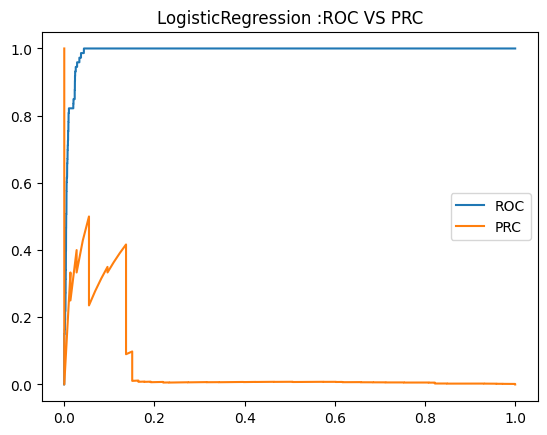

-----------------------LogisticRegression-----------------------
Accuracy: 0.9999304763229022
Recall: 0.9999304763229022
Precision: 0.9998609574793461
F1-score: 0.9998957156927807
MSE: 6.728479596003881e-05


In [66]:
y_pred_proba, classifer, eval = fit_eval_model(
    binary_model_dict['LogisticRegression'],
    X_train, y_train_binary,
    X_test, y_test_binary,
    label_name = 'LogisticRegression')

In [31]:
X

array([[0., 1., 0., ..., 1., 1., 1.],
       [0., 1., 0., ..., 1., 1., 2.],
       [1., 0., 0., ..., 2., 1., 1.],
       ...,
       [1., 0., 0., ..., 1., 1., 3.],
       [0., 0., 0., ..., 1., 1., 2.],
       [1., 0., 0., ..., 1., 1., 3.]])